In [1]:
from util import *
import pandas as pd
import numpy as np
import deepchem as dc
import warnings
import os

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
results = {}

## Graph Convolutional Models

In [3]:
# load esol dataset from csv
tasks = ['measured log solubility in mols per litre']
loader = dc.data.CSVLoader(tasks=tasks, feature_field="smiles", featurizer=dc.feat.ConvMolFeaturizer())
dataset = loader.create_dataset('esol.csv')

# split esol dataset
splitter = dc.splits.RandomSplitter()
train_set, test_set = splitter.train_test_split(dataset, frac_train=0.8, seed=0)

In [ ]:
hyper_params = {
    'batch_size': [32, 16],
    'graph_conv_layers': [[128, 128], [256, 256], [512, 512]],
    'dense_layer_size': [512, 256, 128],
    'dropout': [0.0],
}

search_results, (batch_size, conv_layers, layer_sizes, dropout_rate) = grid_search_graph_conv(train_set, hyper_params)

In [5]:
print(search_results)

        rmse  batch_size conv_layers  layer_sizes  dropout_rate
14  0.909815          16  [256, 256]          128           0.0
16  0.925040          16  [512, 512]          256           0.0
7   0.927719          32  [512, 512]          256           0.0
17  0.932643          16  [512, 512]          128           0.0
11  0.934425          16  [128, 128]          128           0.0
5   0.939430          32  [256, 256]          128           0.0
8   0.943036          32  [512, 512]          128           0.0
10  0.945521          16  [128, 128]          256           0.0
13  0.946772          16  [256, 256]          256           0.0
2   0.949801          32  [128, 128]          128           0.0
9   0.953160          16  [128, 128]          512           0.0
3   0.961466          32  [256, 256]          512           0.0
12  0.962208          16  [256, 256]          512           0.0
4   0.966723          32  [256, 256]          256           0.0
15  0.969348          16  [512, 512]    

In [6]:
transformers = [dc.trans.NormalizationTransformer(transform_y=True, dataset=train_set, move_mean=True)]

# preprocess data
for transformer in transformers:
    train_set = transformer.transform(train_set)
    test_set = transformer.transform(test_set)

# intantiate and fit model
model = dc.models.GraphConvModel(1, mode='regression', batch_size=batch_size, graph_conv_layers=conv_layers, dense_layer_size=layer_sizes, dropout=dropout_rate)
model.fit(train_set, nb_epoch=100)

# evaluate model
metric = [
    dc.metrics.Metric(dc.metrics.rms_score, np.mean),
    dc.metrics.Metric(dc.metrics.mae_score, np.mean),
    dc.metrics.Metric(dc.metrics.pearson_r2_score, np.mean)
]
train_scores = model.evaluate(train_set, metric, transformers)
test_scores = model.evaluate(test_set, metric, transformers)

print("Train scores")
print(train_scores)

print("Test scores")
print(test_scores)

results['gcm'] = test_scores

Train scores
{'mean-rms_score': 0.39749705901679855, 'mean-mae_score': 0.32439183461783083, 'mean-pearson_r2_score': 0.9683124191242287}
Test scores
{'mean-rms_score': 0.7843367191956222, 'mean-mae_score': 0.6250962894537979, 'mean-pearson_r2_score': 0.867844137654933}


## Message Passing Neural Network

In [7]:
# load esol dataset from csv
tasks = ['measured log solubility in mols per litre']
loader = dc.data.CSVLoader(tasks=tasks, feature_field="smiles", featurizer=dc.feat.WeaveFeaturizer())
dataset = loader.create_dataset('esol.csv')

# split esol dataset
splitter = dc.splits.RandomSplitter()
train_set, test_set = splitter.train_test_split(dataset, frac_train=0.8, seed=0)

In [8]:
hyper_params = {
    'batch_size': [32, 16],
    'n_atom_feat': [75],
    'n_pair_feat': [14],
    'n_hidden': [100]
}

search_results, (batch_size, n_atom_feat, n_pair_feat, n_hidden) = grid_search_mpnn(train_set, hyper_params)

[####################                    ]

In [9]:
print(search_results)

       rmse  batch_size  n_atom_feat  n_pair_feat  n_hidden
0  0.679996          32           75           14       100
1  0.686250          16           75           14       100


In [10]:
transformers = [dc.trans.NormalizationTransformer(transform_y=True, dataset=train_set, move_mean=True)]

# preprocess data
for transformer in transformers:
    train_set = transformer.transform(train_set)
    test_set = transformer.transform(test_set)

# intantiate and fit model
model = dc.models.MPNNModel(1, mode='regression', batch_size=batch_size, use_queue=False, n_atom_feat=n_atom_feat, n_pair_feat=n_pair_feat, n_hidden=n_hidden, learning_rate=0.0001, T=3, M=5)
model.fit(train_set, nb_epoch=50, checkpoint_interval=100)

# evaluate model
metric = [
    dc.metrics.Metric(dc.metrics.rms_score, np.mean),
    dc.metrics.Metric(dc.metrics.mae_score, np.mean),
    dc.metrics.Metric(dc.metrics.pearson_r2_score, np.mean)
]
train_scores = model.evaluate(train_set, metric, transformers)
test_scores = model.evaluate(test_set, metric, transformers)

print("Train scores")
print(train_scores)

print("Test scores")
print(test_scores)

results['mpnn'] = test_scores

Train scores
{'mean-rms_score': 0.47224031965659397, 'mean-mae_score': 0.36102604904376745, 'mean-pearson_r2_score': 0.9631306808853515}
Test scores
{'mean-rms_score': 0.6103362570698991, 'mean-mae_score': 0.47893592794330364, 'mean-pearson_r2_score': 0.9197362733301125}


## Random Forest Regressor

In [11]:
# load esol dataset from csv
tasks = ['measured log solubility in mols per litre']
loader = dc.data.CSVLoader(tasks=tasks, feature_field="smiles", featurizer=dc.feat.CircularFingerprint(size=2048, radius=4))
dataset = loader.create_dataset('esol.csv')

# split esol dataset
splitter = dc.splits.RandomSplitter()
train_set, test_set = splitter.train_test_split(dataset, frac_train=0.8, seed=0)

In [12]:
hyper_params = {
    'n_estimators': [250, 500, 1000],
    'criterion': ['mse', 'mae'],
    'max_features': ['auto']
}

search_results, (n_estimators, criterion, max_features) = grid_search_random_forest(train_set, hyper_params)

[####################      ]

In [13]:
print(search_results)

       rmse  n_estimators criterion max_features
2  1.225431           500       mse         auto
4  1.225469          1000       mse         auto
0  1.226358           250       mse         auto
1  1.233063           250       mae         auto
3  1.235029           500       mae         auto
5  1.235786          1000       mae         auto


In [14]:
from sklearn.ensemble import RandomForestRegressor

# intantiate and fit model
sklearn_model = RandomForestRegressor(n_estimators=n_estimators, criterion=criterion, max_features=max_features, random_state=0)
model = dc.models.SklearnModel(sklearn_model)
model.fit(train_set)

# evaluate model
metric = [
    dc.metrics.Metric(dc.metrics.rms_score, np.mean),
    dc.metrics.Metric(dc.metrics.mae_score, np.mean),
    dc.metrics.Metric(dc.metrics.pearson_r2_score, np.mean)
]
train_scores = model.evaluate(train_set, metric, [])
test_scores = model.evaluate(test_set, metric, [])

print("Train scores")
print(train_scores)

print("Test scores")
print(test_scores)

results['rfr'] = test_scores

Train scores
{'mean-rms_score': 0.4557074378032759, 'mean-mae_score': 0.32590803615678415, 'mean-pearson_r2_score': 0.965785107964993}
Test scores
{'mean-rms_score': 1.1422869134998823, 'mean-mae_score': 0.8716654813527174, 'mean-pearson_r2_score': 0.7005435810374528}


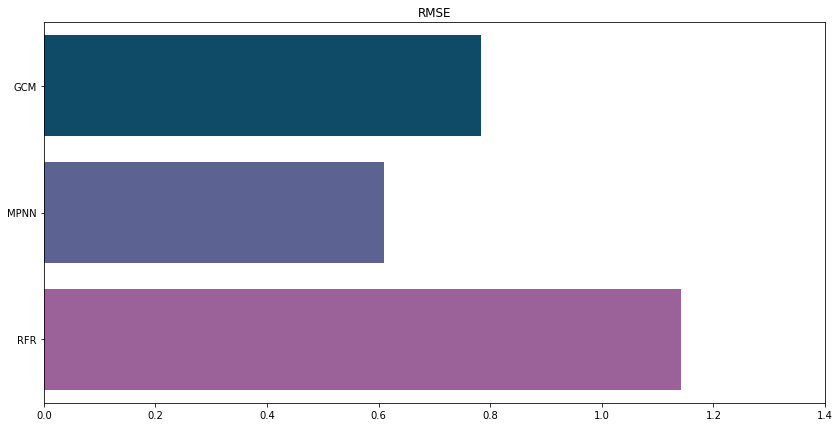

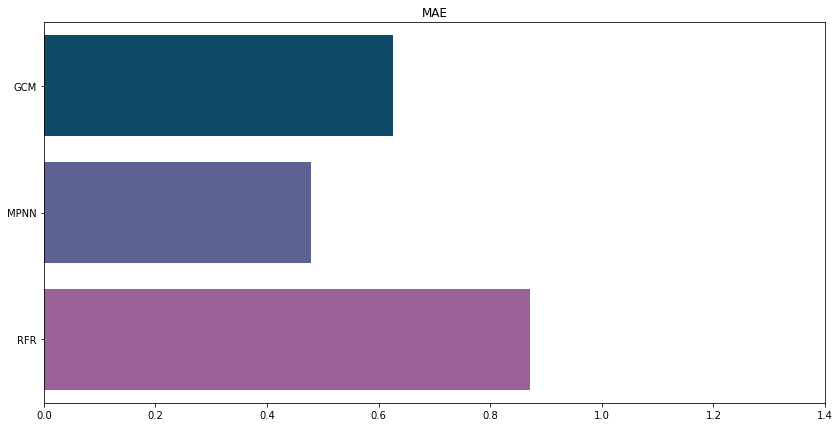

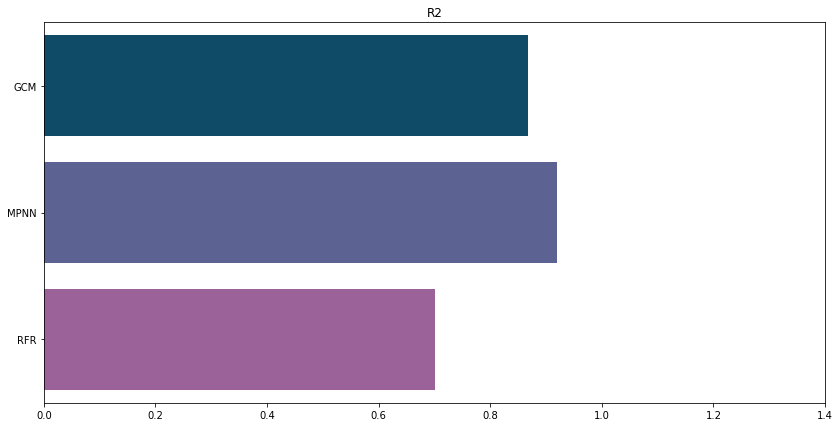

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

color_palette = ['#005075', '#535b9a', '#a459a3']
score_keys = ['mean-rms_score', 'mean-mae_score', 'mean-pearson_r2_score']
plot_titles = ['RMSE', 'MAE', 'R2']

# draw bar plots
for score_key, plot_title in zip(score_keys, plot_titles):

    scores = [results['gcm'][score_key], results['mpnn'][score_key], results['rfr'][score_key]]
    model_labels = ['GCM', 'MPNN', 'RFR']

    fig = plt.figure(figsize=(14, 7), facecolor='w')
    sns.barplot(scores, model_labels, orient='h', palette=color_palette)
    plt.title(plot_title)
    plt.xlim([0, 1.4])
    plt.savefig('images/%s.png' % plot_title.lower())